# Customer Segmentation with K - Means

## Importing Packages

In [1]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt

## Creating the data

In [2]:
#Importing tables
transactions=pd.read_excel('data/grocery_database.xlsx', sheet_name='transactions')
product_areas=pd.read_excel('data/grocery_database.xlsx', sheet_name='product_areas')

In [18]:
transactions

,customer_id,transaction_date,transaction_id,product_area_id,num_items,sales_cost,product_area_name,profit_margin
0,1,2020-04-10,435657533999,3,7,19.16,Fruit,0.14
1,1,2020-07-20,436667313620,3,8,19.99,Fruit,0.14
2,1,2020-07-22,436686191960,3,20,61.69,Fruit,0.14
3,1,2020-08-12,436899350757,3,16,52.28,Fruit,0.14
4,1,2020-08-13,436908803653,3,14,34.58,Fruit,0.14
...,...,...,...,...,...,...,...,...
38501,870,2020-08-07,436848060721,5,3,27.00,Meat,0.11
38502,870,2020-08-16,436933386887,5,4,35.34,Meat,0.11
38503,870,2020-09-21,437291420399,5,2,20.40,Meat,0.11
38504,870,2020-09-23,437316479610,5,4,51.61,Meat,0.11


In [17]:
product_areas

,product_area_id,product_area_name,profit_margin
0,1,Non-Food,0.25
1,2,Vegetables,0.18
2,3,Fruit,0.14
3,4,Dairy,0.19
4,5,Meat,0.11


In [3]:
#Merging on product area name
transactions=pd.merge(transactions,product_areas, how='inner', on= 'product_area_id')

In [4]:
#Dropping the non food category
transactions.drop(transactions[transactions['product_area_name']=='Non-Food'].index, inplace=True)

In [5]:
#Aggregating sales on customer level (by product area)
transactions_summary=transactions.groupby(['customer_id','product_area_name' ])['sales_cost'].sum().reset_index()

In [6]:
#Pivoting data to place product area as columns
transactions_summary_pivot=transactions.pivot_table(index='customer_id',
                                                    columns='product_area_name',
                                                    values='sales_cost',
                                                    aggfunc='sum',
                                                    fill_value=0,
                                                    margins=True,
                                                    margins_name='Total').rename_axis(None, axis=1)

In [7]:
#Turning Sales into % Sales
transactions_summary_pivot=transactions_summary_pivot.div(transactions_summary_pivot['Total'], axis=0)

In [8]:
#Droppin the 'Total' column
data_for_clustering=transactions_summary_pivot.drop(['Total'], axis=1)

## Data preparation & Cleaning


In [9]:
#Checking for missing values
data_for_clustering.isna().sum()

Dairy         0
Fruit         0
Meat          0
Vegetables    0
dtype: int64

In [10]:
#Normalising data
scale_norm=MinMaxScaler()
data_for_clustering_scaled=pd.DataFrame(scale_norm.fit_transform(data_for_clustering), columns=data_for_clustering.columns)

## Using WCSS to decide number of K


C:\Users\costa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


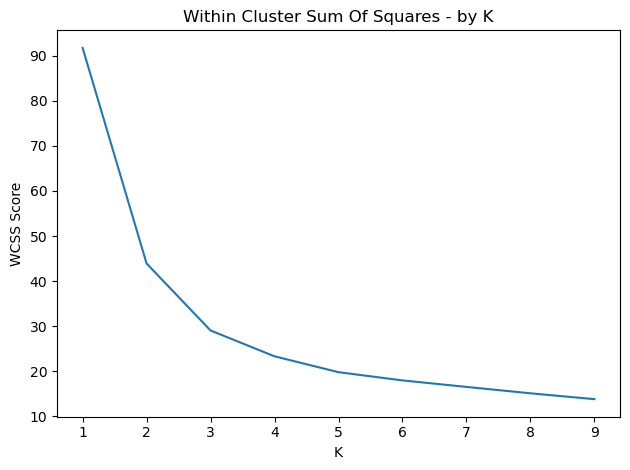

In [11]:
k_values=list(range(1,10))
wcss_list=[]
for k in k_values:
    kmeans=KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_for_clustering_scaled)
    wcss_list.append(kmeans.inertia_)
    
plt.plot(k_values, wcss_list)
plt.title('Within Cluster Sum Of Squares - by K')
plt.xlabel('K')
plt.ylabel('WCSS Score')
plt.tight_layout()
plt.show()

## Instantiating and fitting the model


In [12]:
kmeans=KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_for_clustering_scaled)

KMeans(n_clusters=3, random_state=42)

## Using cluster information


In [14]:
#Add cluster label to data
data_for_clustering['cluster']=kmeans.labels_

In [15]:
#Check cluster size
data_for_clustering['cluster'].value_counts()

0    641
2    127
1    103
Name: cluster, dtype: int64

## Profiling our customers

In [16]:
cluster_summary=data_for_clustering.groupby('cluster')[['Dairy','Fruit','Meat','Vegetables']].mean().reset_index()
cluster_summary

,cluster,Dairy,Fruit,Meat,Vegetables
0,0,0.220875,0.264605,0.376508,0.138011
1,1,0.002382,0.637796,0.003696,0.356126
2,2,0.363948,0.394152,0.029210,0.212690
